In [1]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Importing functions from the modules in the qseg package
from qseg.graph_utils import image_to_grid_graph, draw, draw_graph_cut_edges
from qseg.utils import decode_binary_string

# Additional necessary imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import cirq

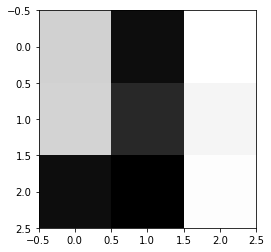

In [2]:
height, width = 3, 3

image = np.array([
       [0.82,  0.1, 0.99],
       [0.83,  0.2, 0.95],
       [0.1,  0.05, 0.98]
       ])
plt.imshow(image, cmap=plt.cm.gray)



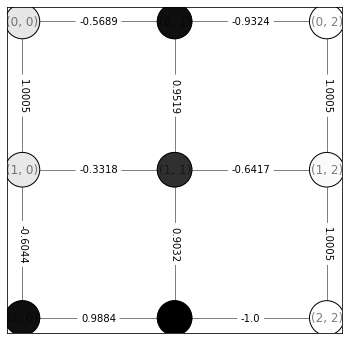

In [3]:
# Convert image to graph
normalized_nx_elist = image_to_grid_graph(image)  # Gaussian similarity metric as the edge weight metric
G = nx.grid_2d_graph(image.shape[0], image.shape[1])
G.add_weighted_edges_from(normalized_nx_elist)
draw(G, image)

In [4]:
# Define quantum circuit for max-cut approximation
def cirq_maxcut_solver(G, n_shots=1000):
    qubits = [cirq.GridQubit(i, j) for i in range(height) for j in range(width)]
    circuit = cirq.Circuit()
    
    for qubit in qubits:
        circuit.append(cirq.H(qubit))  # Apply Hadamard gate
    
    for u, v in G.edges():
        qubit_u = cirq.GridQubit(*u)
        qubit_v = cirq.GridQubit(*v)
        circuit.append(cirq.CNOT(qubit_u, qubit_v))
    
    circuit.append(cirq.measure(*qubits, key='result'))
    
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=n_shots)
    return result.measurements['result']

In [5]:
# Run quantum solver
import time
start_time = time.time()
samples = cirq_maxcut_solver(G)
total_time = time.time() - start_time

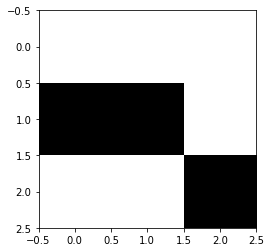

In [6]:
# Convert results to binary segmentation mask
solution_binary_string = ''.join(map(str, samples[0]))
segmentation_mask = decode_binary_string(solution_binary_string, height, width)
plt.imshow(segmentation_mask, cmap=plt.cm.gray)


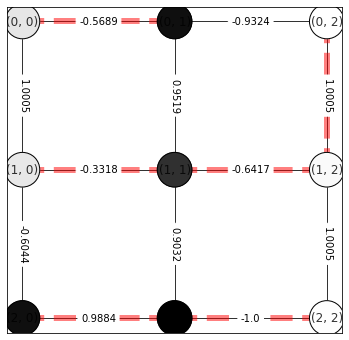

In [7]:
# Extract cut edges
cut_edges = [(u, v) for (u, v, d) in G.edges(data=True) if segmentation_mask[u] != segmentation_mask[v]]
draw_graph_cut_edges(G, image, cut_edges)